# Machine Learning Project

## Track T5- Diagnosis of pneumonia
The aim of the project is to build a model of ML which can recognize pneumonia in people through radiography. The dataset consists of about 5000 x-rays divided into NORMAL and PNEUMONIA

#### Importe libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
from shutil import copyfile
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.models import Sequential



2025-02-20 09:52:20.972051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 09:52:21.228629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740041541.341085    1258 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740041541.373621    1258 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 09:52:21.615645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Data preparation

In [2]:
train_dir = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/chest_xray/train"
validation_dir = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/chest_xray/validation"
test_dir = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/chest_xray/test"

Let’s see some examples of X-rays of healthy people and people with pneumonia

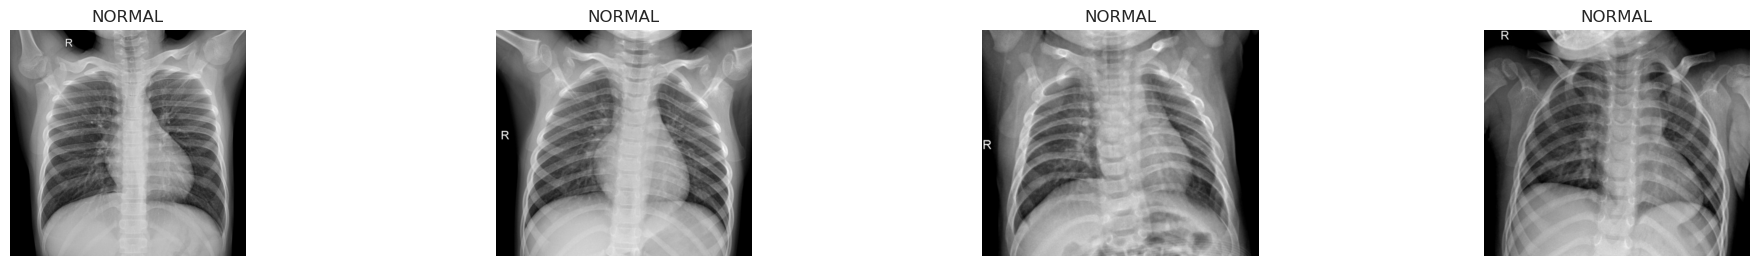

In [ ]:
plt.figure(figsize=(20, 10))
directory = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/chest_xray/train/NORMAL"
for i in range(4):
    plt.subplot(4, 4, i + 1)
    images = os.listdir(directory)
    img = plt.imread(os.path.join(directory, images[i]))
    plt.imshow(img, cmap='gray')# Display the image in grayscale
    plt.axis('off') # Hide the axis for better visualization
    plt.title("NORMAL") # Set the title for the image
plt.tight_layout()# Adjust layout to avoid overlapping elements

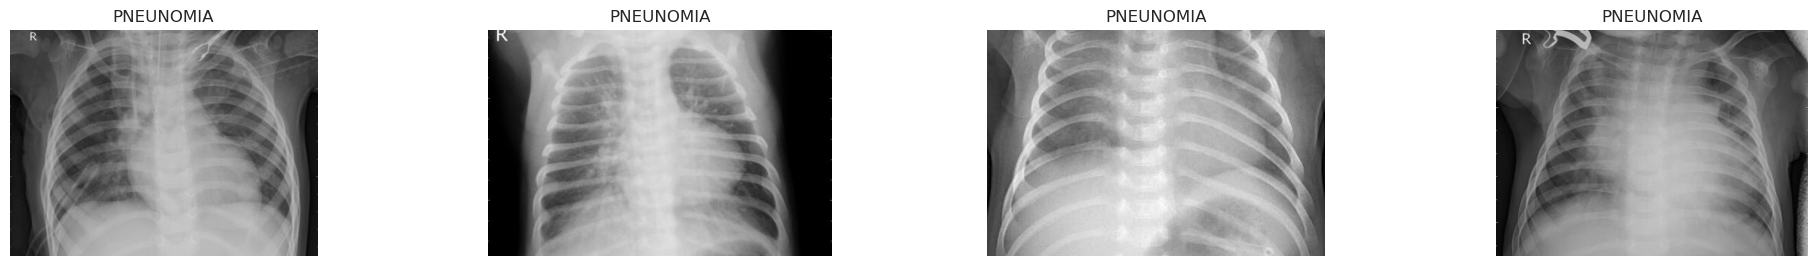

In [ ]:
plt.figure(figsize=(20, 10))
directory = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/chest_xray/train/PNEUMONIA"
for i in range(4):
    plt.subplot(4, 4, i + 1)
    images = os.listdir(directory)
    img = plt.imread(os.path.join(directory, images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("PNEUNOMIA")
plt.tight_layout()

##### Create Validation set
I randomly split train folder data into a training set and validation set; the training set is used to train the different models and the validation set to calculate the errors on new predictions. The split I used is approximately: 80% training set and 20% validation set.

I used the function train_test_split, offered by Scikit-learn for this task.

In [3]:
labels = ["PNEUMONIA", "NORMAL"]

# Create the validation directory if it does not exist
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

    for label in labels:
        # Paths for each class
        class_train_dir = os.path.join(train_dir, label)
        class_validation_dir = os.path.join(validation_dir, label)

        # Create directories for the classes in validation if they do not exist
        if not os.path.exists(class_validation_dir):
            os.makedirs(class_validation_dir)

        # Get all files of the class
        files = os.listdir(class_train_dir)
        files = [os.path.join(class_train_dir, file) for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

        # Split files into training and validation (80% train, 20% validation)
        train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

        # Move validation files to the corresponding folder
        for file in val_files:
            shutil.move(file, os.path.join(class_validation_dir, os.path.basename(file)))

        print(f"Classe '{label}': {len(train_files)} file nel training set, {len(val_files)} file nel validation set")

##### Control of data distribution

<Axes: ylabel='count'>

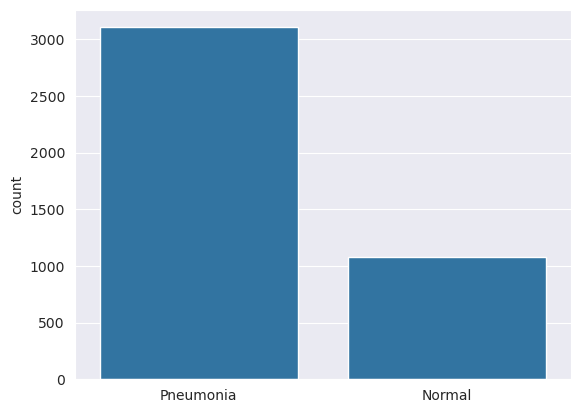

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    labels_list = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # Assign 0 to NORMAL and 1 to PNEUMONIA
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                labels_list.append(class_num)  # Adds class separately
            except Exception as e:
                print(e)
    return np.array(labels_list) 

train_labels = get_data(train_dir)

label_counts = {0: "Pneumonia", 1: "Normal"}
class_labels = [label_counts[label] for label in train_labels]

sns.set_style("darkgrid")
sns.countplot(x=class_labels)


As we can see the dataset is unbalanced, since the "NORMAL" class has many fewer samples. To overcome this problem we will use a technique called **data augmentation**, which allows us to create new synthetic data by applying small transformations to our original images. The aim of this technique is to make the model more general. 
We will see two types of data augmentation, one in which there will be slight changes and one in which there will be stronger changes

In [5]:
img_height, img_width = 224, 224

### First Data Augmentation

In the first type of data augmentation we perform the following transformations:
- We move the image horizontally up to 10%
- We move the image vertically up to 10%
- We zoom random up to 10%

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  # Resize each image
    color_mode="grayscale",
    batch_size=32, # Number of images per batch
    class_mode='binary' # label type
)


Found 4185 images belonging to 2 classes.


We plot an example of a data augmentation

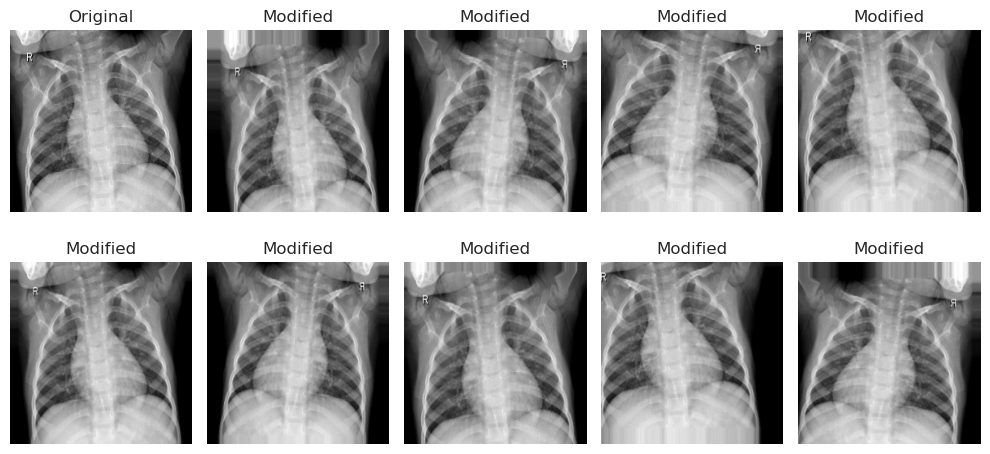

In [ ]:
# Upload a single image
img_path = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/chest_xray/train/NORMAL/NORMAL-32326-0001.jpeg"
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Generate augmented images
augmented_images = train_datagen.flow(img_array, batch_size=1)

plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(2, 5, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original")

# Generate and display 9 augmented images
for i in range(9):
    batch = next(augmented_images)  # Get a transformed image
    plt.subplot(2, 5, i + 2)
    plt.imshow(batch[0])  # batch[0] because it's a batch of a single image
    plt.title("Modified")
    plt.axis('off')

plt.tight_layout()
plt.show()

Let’s create and also prepare the validation and test data, normalizing them.

In [ ]:

evaluate_datagen = ImageDataGenerator(
    rescale=1./255, #pixel normalization between 0 and 1
)

valid_generator = evaluate_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),  
    color_mode="grayscale", 
    batch_size=32, 
    class_mode='binary' 
)

test_generator = evaluate_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),  
    color_mode="grayscale",  
    shuffle=False,  # Important to keep images in order
    batch_size=32, 
    class_mode='binary' 
)

Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Model creation
The model uses multiple convolutional layers to extract visual characteristics, followed by pooling layers to reduce dimensionality. After feature extraction, the output is flattened and passed through dense layers for final classification, with sigmoidal activation for binary prediction (e.g. pneumonia vs normal).

In [ ]:
cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape=(img_height, img_width, 1)), # Adds a two-dimensional convolutional layer with 32 filters, each of 3x3 size
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'), # Adds a two-dimensional maximum pooling layer with a 2x2 window
    
    keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Flatten(), # Converts the three-dimensional output of previous layers into a one-dimensional vector, preparing it for subsequent dense layers
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
cnn_model1 = cnn_model

cnn_model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

cnn_model1.summary()

/home/carlos/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739984064.956878  118445 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,341,121 (12.75 MB)

 Trainable params: 3,341,121 (12.75 MB)

 Non-trainable params: 0 (0.00 B)

We use early stopping to stop training when performance does not improve for a number of eras

In [7]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)

In [ ]:
epochs=100
history = cnn_model1.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping])

/home/carlos/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1739984071.641290  118624 service.cc:148] XLA service 0x7fb92801ce00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739984071.641327  118624 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-02-19 17:54:31.662795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739984071.804289  118624 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/131 ━━━━━━━━━━━━━━━━━━━━ 13:26 6s/step - binary_accuracy: 0.8125 - loss: 0.6840

I0000 00:00:1739984076.819285  118624 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - binary_accuracy: 0.7749 - loss: 0.5274 - val_binary_accuracy: 0.9160 - val_loss: 0.2390
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - binary_accuracy: 0.8944 - loss: 0.2533 - val_binary_accuracy: 0.9179 - val_loss: 0.1919
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - binary_accuracy: 0.9105 - loss: 0.2158 - val_binary_accuracy: 0.9408 - val_loss: 0.1629
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - binary_accuracy: 0.9302 - loss: 0.1669 - val_binary_accuracy: 0.9475 - val_loss: 0.1393
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 194ms/step - binary_accuracy: 0.9228 - loss: 0.1956 - val_binary_accuracy: 0.9255 - val_loss: 0.1803
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - binary_accuracy: 0.9425 - loss: 0.1606 - val_binary_accuracy: 0.9408 - val_loss: 0.1466
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - binary_accuracy: 0.9430 - loss: 0.1520 - val_binary_accuracy: 0.9561 - val_los

We plot the training history

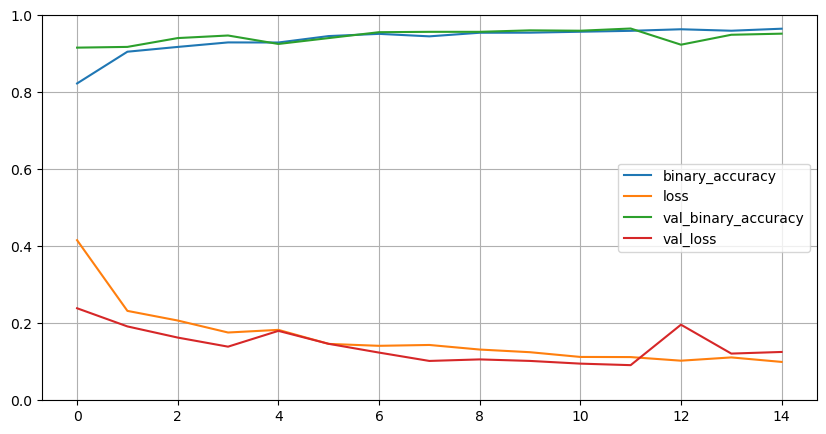

In [9]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
cnn_model1.save('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/CNN1.keras')  # Salva il modello in locale

### Second Data Augmentation

In the second type of data augmentation we perform the following transformations:
- Images can rotate up to 15°
- Images can move horizontally up to 20%
- Images can move vertically up to 20%
- Images can zoom random up to 20%
- Images can be mirrored horizontally
- Image brightness is changed by 20%

In [ ]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=15,  
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
)

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width), 
    color_mode="grayscale", 
    batch_size=32,
    class_mode='binary'
)

Found 4185 images belonging to 2 classes.


In [ ]:
cnn_model2 = cnn_model

cnn_model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

cnn_model2.summary()

In [ ]:
epochs=100
history2 = cnn_model1.fit(train_generator2, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping])

/home/carlos/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1739982936.909126  114005 service.cc:148] XLA service 0x7fda3000cd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739982936.909163  114005 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-02-19 17:35:36.930260: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739982937.067376  114005 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/131 ━━━━━━━━━━━━━━━━━━━━ 13:45 6s/step - binary_accuracy: 0.6250 - loss: 0.6925

I0000 00:00:1739982942.190762  114005 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/131 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - binary_accuracy: 0.7730 - loss: 0.4925

2025-02-19 17:36:06.126301: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=0,k13=2,k14=3,k18=0,k23=0} for conv (f32[25,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-19 17:36:06.126668: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.938172774s
Trying algorithm eng28{k2=0,k13=2,k14=3,k18=0,k23=0} for conv (f32[25,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", b

131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 271ms/step - binary_accuracy: 0.7780 - loss: 0.4825 - val_binary_accuracy: 0.7956 - val_loss: 0.4277
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - binary_accuracy: 0.8880 - loss: 0.2709 - val_binary_accuracy: 0.9045 - val_loss: 0.2417
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - binary_accuracy: 0.8918 - loss: 0.2686 - val_binary_accuracy: 0.8720 - val_loss: 0.2694
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - binary_accuracy: 0.8972 - loss: 0.2380 - val_binary_accuracy: 0.8185 - val_loss: 0.3642
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - binary_accuracy: 0.8992 - loss: 0.2399 - val_binary_accuracy: 0.9102 - val_loss: 0.2228
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - binary_accuracy: 0.9068 - loss: 0.2395 - val_binary_accuracy: 0.8902 - val_loss: 0.2421
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - binary_accuracy: 0.9074 - loss: 0.2242 - val_binary_accuracy: 0.9226 - val_los

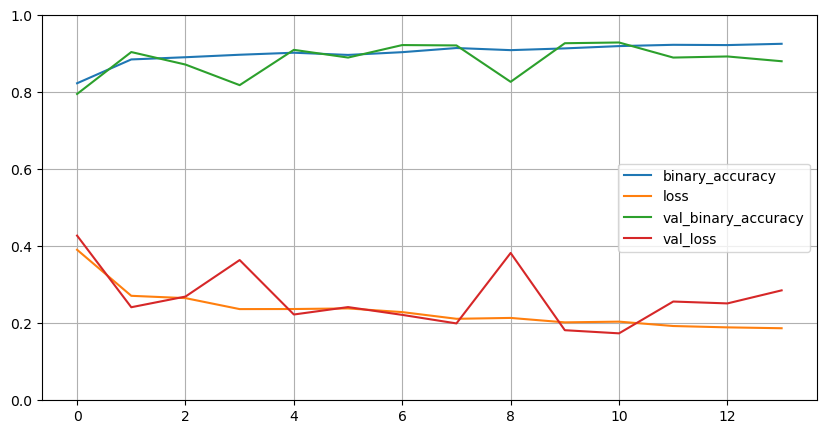

In [10]:
pd.DataFrame(history2.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
cnn_model1.save('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/CNN2.keras')  # Salva il modello in locale

---

### Testing
During this phase we evaluate the performance of the model with the two types of data augmentation and then compare them. To do this we evaluate accuracy and loss on the test set and then go to see other metrics like precision, recall etc...

We test the model first with the first type of data augmentation

In [ ]:
cnn_model1= load_model('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/CNN1.keras')

I0000 00:00:1740041584.171042    1258 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/carlos/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
### model with first data augmentation form
evaluation = cnn_model1.evaluate(test_generator)
accuracy1 = evaluation[1]
loss1 = evaluation[0]
print(f"Test Accuracy: {accuracy1* 100:.2f}%")
print(f"Test Loss: {loss1}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - binary_accuracy: 0.7776 - loss: 0.4694
Test Accuracy: 87.98%
Test Loss: 0.28477713465690613


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.69      0.81       234
   PNEUMONIA       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.90      0.88      0.87       624



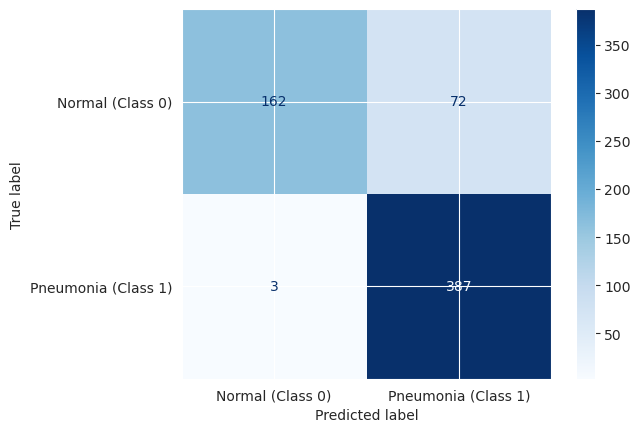

In [ ]:
### model with first data augmentation form
batch_size=32

predictions = cnn_model1.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype(int)
y_test = test_generator.classes
# Calculate the classification report
report = classification_report(y_test, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

After that we test the trained model with the second type of data augmentation

In [ ]:
cnn_model2= load_model('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/Progetto-ML/CNN2.keras')

In [ ]:
### model with second form of data augmentation

evaluation2 = cnn_model2.evaluate(test_generator)
accuracy2 = evaluation2[1]
loss2 = evaluation2[0]
print(f"Test Accuracy: {accuracy2 * 100:.2f}%")
print(f"Test Loss: {loss2}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - binary_accuracy: 0.7447 - loss: 0.5594
Test Accuracy: 84.94%
Test Loss: 0.3547317087650299


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step
              precision    recall  f1-score   support

      NORMAL       0.91      0.67      0.77       234
   PNEUMONIA       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



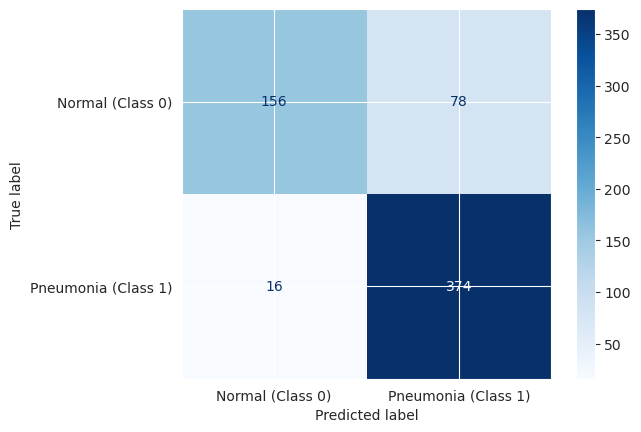

In [ ]:
### model with second form of data augmentation
batch_size=32

predictions = cnn_model2.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype(int)  # Converte le probabilità in classi binarie
y_test = test_generator.classes
# Calculate the classification report
report = classification_report(y_test, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

We can see that the second type of data augmentation causes worse performance than the first, because it alters too much the images, while the first makes slight modifications that allow the model to generalize better, but without altering the nature of the radiographs.

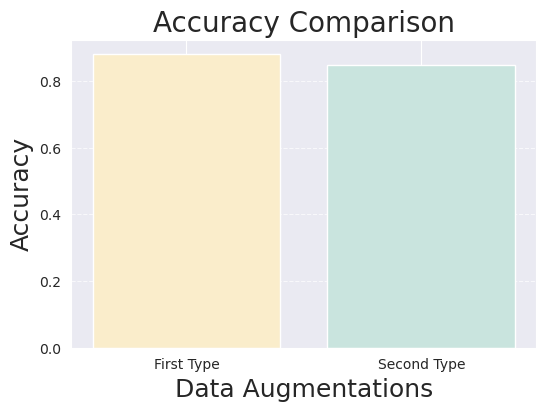

In [33]:
models = ['First Type', 'Second Type']
accuracy = [accuracy1, accuracy2]
loss = [loss1, loss2]

# Accuracy plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracy, color=['#faedcb','#c9e4de'])
plt.xlabel('Data Augmentations', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.title('Accuracy Comparison', fontsize = 20)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

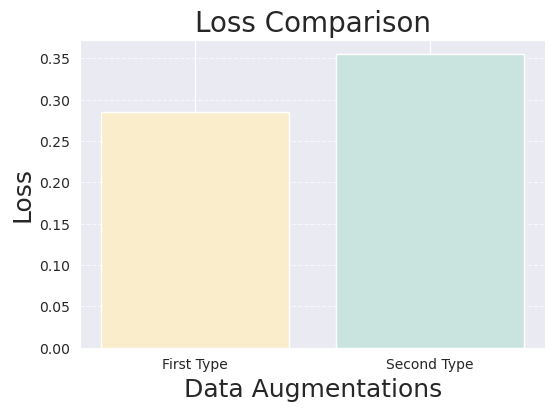

In [35]:
# Loss plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, loss, color=['#faedcb','#c9e4de'])
plt.xlabel('Data Augmentations', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.title('Loss Comparison', fontsize = 20)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

#### False positives or False negatives
We let the user choose whether he wants to reduce false positives or false negatives and based on this we modify the threshold for which we label an image as "NORMAL" or as "PNEUMONIA"

Utilizzando soglia di 0.7
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.81      0.88       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



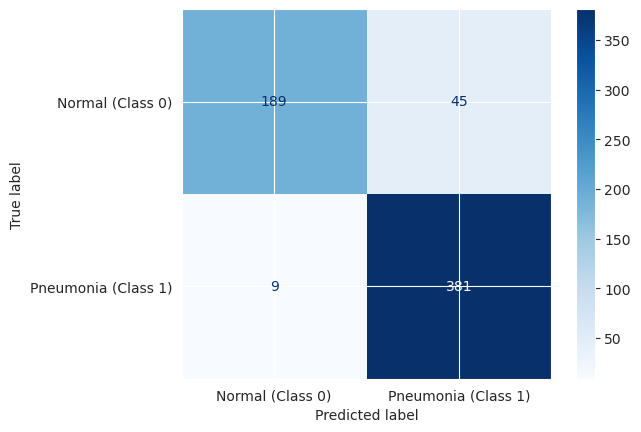

In [ ]:
# Ask the user for the classification focus
user_preference = input("Do you want to reduce (1) False Positives or (2) False Negatives? Enter 1 or 2: ")

# Set the threshold based on the choice
if user_preference == "1":
    threshold = 0.7  # Reduces FP, but increases FN
elif user_preference == "2":
    threshold = 0.3  # Reduces FN, but increases FP
else:
    threshold = 0.5  # Default

print(f"Using threshold of {threshold}")

### Using the model with the first form of data augmentation that performs better
batch_size=32

predictions = cnn_model1.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = (predictions > threshold).astype(int)  # Converts probabilities into binary classes
y_test = test_generator.classes

# Compute the classification report
report = classification_report(y_test, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

---
#### Inference 

Let’s try to plot some predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


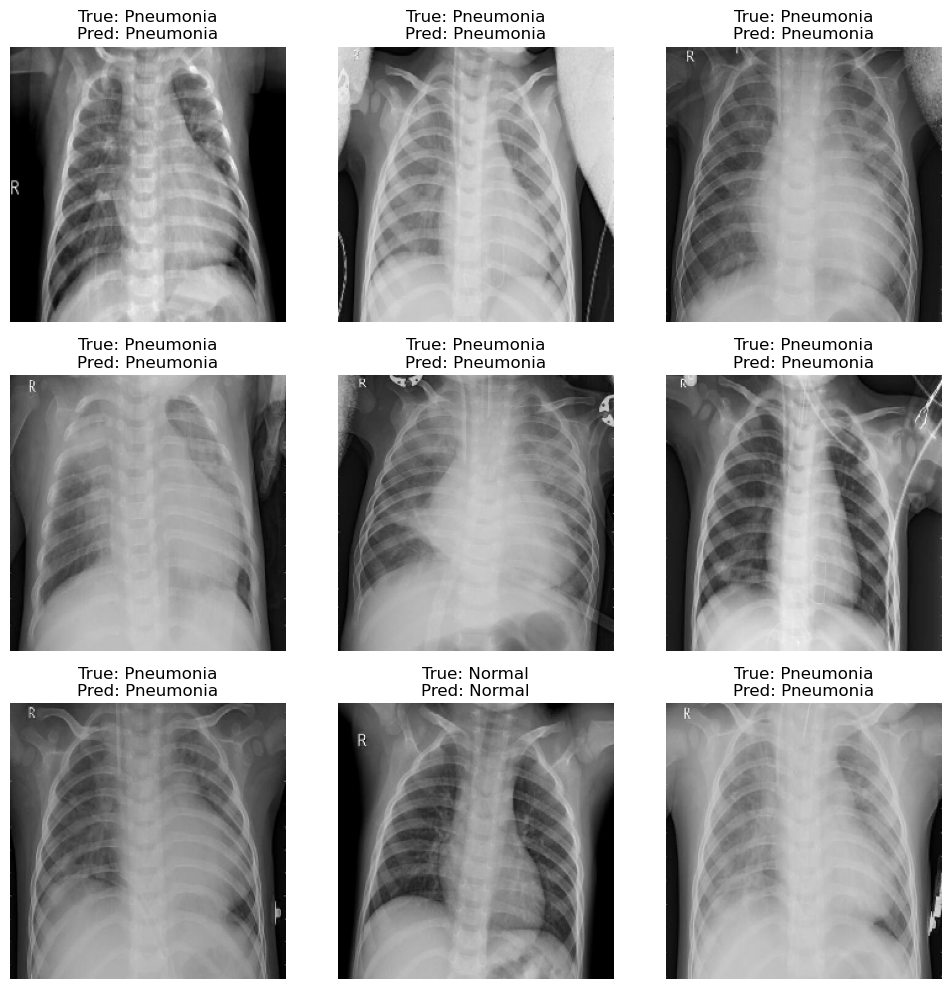

In [ ]:
# Get 9 random images from the test set
x_test, y_test = next(test_generator) 
num_images = 9
indices = np.random.choice(len(x_test), num_images, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]  # True labels
predictions = cnn_model1.predict(sample_images)  # Model predictions

# Convert predictions to binary classes (1 = Pneumonia, 0 = Normal)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Create the plot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten() 

for i in range(num_images):
    ax = axes[i]
    ax.imshow(sample_images[i], cmap="gray")  
    true_label = "Normal" if sample_labels[i] == 0 else "Pneumonia"
    pred_label = "Normal" if predicted_classes[i] == 0 else "Pneumonia"
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color="black")
    ax.axis("off")

plt.tight_layout()
plt.show()
